In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import L0 modules
from l0.layers import L0Linear, L0Conv2d, SparseMLP
from l0.gates import FeatureGate, SampleGate
from l0.penalties import (
    compute_l0_penalty,
    get_sparsity_stats,
    TemperatureScheduler,
    update_temperatures
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


Structured Sparsity Pattern:


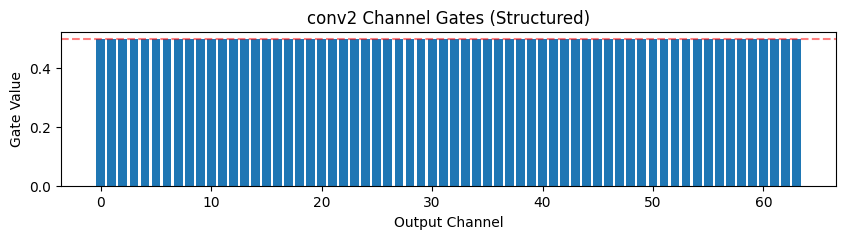


Unstructured Sparsity Pattern:


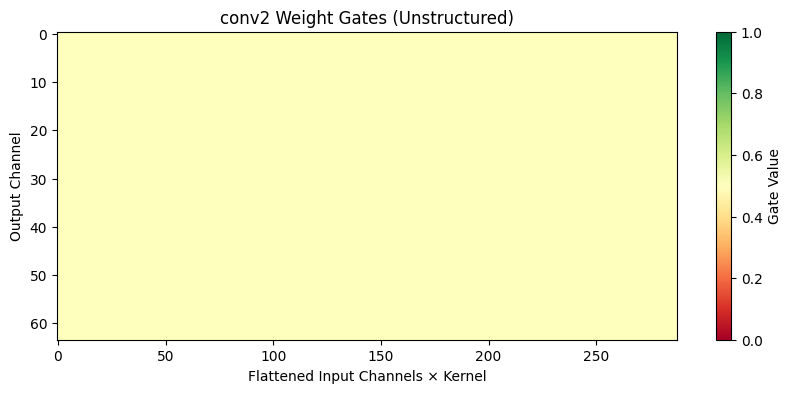

In [3]:
# Visualize structured vs unstructured sparsity patterns
def visualize_conv_sparsity(model, layer_name='conv2'):
    """Visualize sparsity pattern in a conv layer."""
    for name, module in model.named_modules():
        if name == layer_name and isinstance(module, L0Conv2d):
            module.eval()
            with torch.no_grad():
                if model.structured and hasattr(module, 'channel_gates'):
                    # Structured: show channel gates
                    gates = module.channel_gates().cpu().numpy()
                    plt.figure(figsize=(10, 2))
                    plt.bar(range(len(gates)), gates)
                    plt.xlabel('Output Channel')
                    plt.ylabel('Gate Value')
                    plt.title(f'{layer_name} Channel Gates (Structured)')
                    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
                else:
                    # Unstructured: show weight gate heatmap
                    gates = module.weight_gates()
                    # Reshape to (out_channels, -1) for visualization
                    gates_2d = gates.view(gates.shape[0], -1).cpu().numpy()
                    
                    plt.figure(figsize=(10, 4))
                    plt.imshow(gates_2d, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
                    plt.colorbar(label='Gate Value')
                    plt.xlabel('Flattened Input Channels × Kernel')
                    plt.ylabel('Output Channel')
                    plt.title(f'{layer_name} Weight Gates (Unstructured)')
                plt.show()
                break

print("Structured Sparsity Pattern:")
visualize_conv_sparsity(structured_cnn, 'conv2')

print("\nUnstructured Sparsity Pattern:")
visualize_conv_sparsity(unstructured_cnn, 'conv2')

Demonstrating channel-wise structured sparsity for CNNs and temperature annealing effects.